# 🔍  Système CBIR (Content-Based Image Retrieval)

**Préparé par :** Mohamed ZAIM  
**Date :** Octobre 2025  
**Encadrant :** Prof. Abdelouahed Sabri  
**Sujet :** Système de recherche d’images par le contenu basé sur les caractéristiques visuelles et l’analyse de robustesse

---

**Objectif :**  
L’objectif de ce travail est de concevoir un **système de recherche d’images par le contenu (CBIR)** capable de retrouver des images similaires à une image requête en se basant sur leurs **caractéristiques visuelles** : intensité, couleur, texture et forme.

Nous allons également évaluer la **robustesse du système** face à des **transformations géométriques** telles que la rotation, le redimensionnement et le retournement (flip).

---

## 🧩 1. Importation des bibliothèques et des données


In [ ]:
import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2hsv
from skimage import img_as_ubyte
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

dataset_folder = "/content/drive/MyDrive/CBIR_DataSet/obj_decoys"
query_folder   = "/content/drive/MyDrive/CBIR_DataSet/img_requetes"

def load_images_from_folder(folder):
    exts = ('jpg', 'jpeg', 'png', 'bmp')
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, f'*.{e}')))
    files = sorted(files)
    imgs, names = [], []
    for f in files:
        img = cv2.imread(f)
        if img is not None:
            imgs.append(img)
            names.append(f)
    return imgs, names

dataset_imgs, dataset_names = load_images_from_folder(dataset_folder)
query_imgs, query_names = load_images_from_folder(query_folder)

print(f"Dataset: {len(dataset_imgs)} images")
print(f"Queries: {len(query_imgs)} images")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset: 270 images
Queries: 4 images


## 🎨 2. Extraction des Caractéristiques

Nous allons extraire quatre types de caractéristiques :  
- **A. Intensité (Niveaux de gris)**  
- **B. Couleur (Moments statistiques et histogrammes HSV quantifiés)**  
- **C. Texture (GLCM : contraste, corrélation, énergie, homogénéité)**  
- **D. Forme (Moments invariants de Hu)**  
Chaque image sera représentée par un vecteur de caractéristiques obtenu par **concaténation** de ces mesures.


In [ ]:
def color_moments_rgb(img_bgr):
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    feats = []
    for ch in range(3):
        c = img[:, :, ch].ravel()
        feats.extend([np.mean(c), np.std(c)])
    return np.array(feats, dtype=np.float32)

def hsv_quantized_hist(img_bgr, h_bins=8, s_bins=2, v_bins=2):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) / 255.0
    hsv = rgb2hsv(img_rgb)
    H = (hsv[:, :, 0] * (h_bins - 1)).astype(int)
    S = (hsv[:, :, 1] * (s_bins - 1)).astype(int)
    V = (hsv[:, :, 2] * (v_bins - 1)).astype(int)
    hist = np.zeros((h_bins, s_bins, v_bins), dtype=np.float32)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            hist[H[i, j], S[i, j], V[i, j]] += 1
    hist = hist.ravel().astype(np.float32)
    hist /= hist.sum() if hist.sum() > 0 else 1
    return hist

def texture_glcm_features(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_q = img_as_ubyte(gray)
    glcm = graycomatrix(img_q, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    feats = [graycoprops(glcm, p).mean() for p in ('contrast','correlation','energy','homogeneity')]
    return np.array(feats, dtype=np.float32)

def hu_moments(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    hu = cv2.HuMoments(cv2.moments(gray)).ravel()
    return np.sign(hu) * np.log1p(np.abs(hu))

def extract_features(img_bgr):
    A = color_moments_rgb(img_bgr)
    B = hsv_quantized_hist(img_bgr)
    C = texture_glcm_features(cv2.resize(img_bgr, (128,128)))
    D = hu_moments(img_bgr)
    return np.concatenate([A,B,C,D])


## 🧮 3. Indexation du Dataset
Chaque image du dataset est transformée en vecteur de caractéristiques.  
Ces vecteurs sont ensuite normalisés pour un calcul de distance équitable.


In [ ]:
feats_dataset = [extract_features(img) for img in tqdm(dataset_imgs)]
feats_dataset = np.vstack(feats_dataset)
scaler = StandardScaler().fit(feats_dataset)
feats_dataset_scaled = scaler.transform(feats_dataset)


100%|██████████| 270/270 [00:04<00:00, 55.37it/s]


## 🔎 4. Recherche d'Images Similaires
Nous utilisons la **distance euclidienne** entre le vecteur de la requête et ceux du dataset pour trouver les images les plus proches (Top-5).


In [ ]:
def query_image(img_bgr, feats_db, scaler, db_names, top_k=5):
    q = extract_features(img_bgr).reshape(1, -1)
    q_s = scaler.transform(q)
    dists = euclidean_distances(q_s, feats_db).ravel()
    idx_sorted = np.argsort(dists)
    return [(db_names[i], dists[i]) for i in idx_sorted[:top_k]]

def show_results(query_img, results, query_name):
    plt.figure(figsize=(14,4))
    plt.subplot(1, len(results)+1, 1)
    plt.imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
    plt.title("Requête")
    plt.axis('off')
    for i,(name,dist) in enumerate(results):
        img = cv2.imread(name)
        plt.subplot(1, len(results)+1, i+2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"#{i+1}\n{os.path.basename(name)}\n{dist:.3f}")
        plt.axis('off')
    plt.suptitle(f"Résultats pour {os.path.basename(query_name)}")
    plt.show()


## 🧪 5. Analyse des Résultats
Nous testons plusieurs images requêtes pour évaluer la performance visuelle du système.



🔎 Requête : ImageRequete.jpg


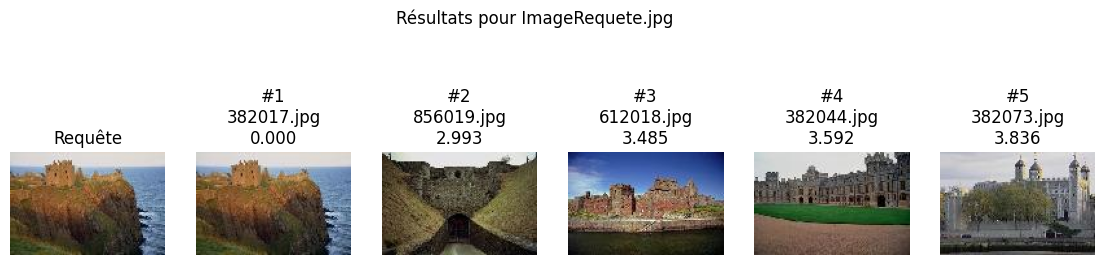


🔎 Requête : ImageRequete2.jpg


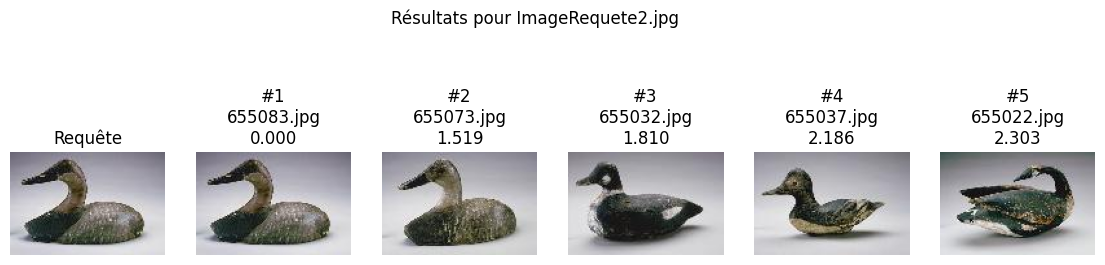


🔎 Requête : ImageRequete2_miroir_up_left .jpg


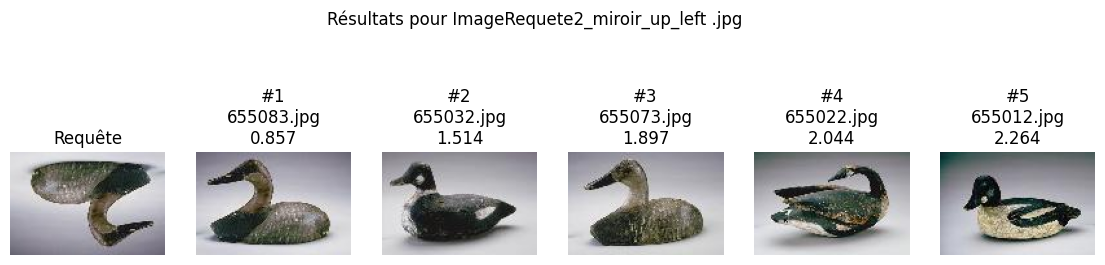


🔎 Requête : ImageRequete_90.jpg


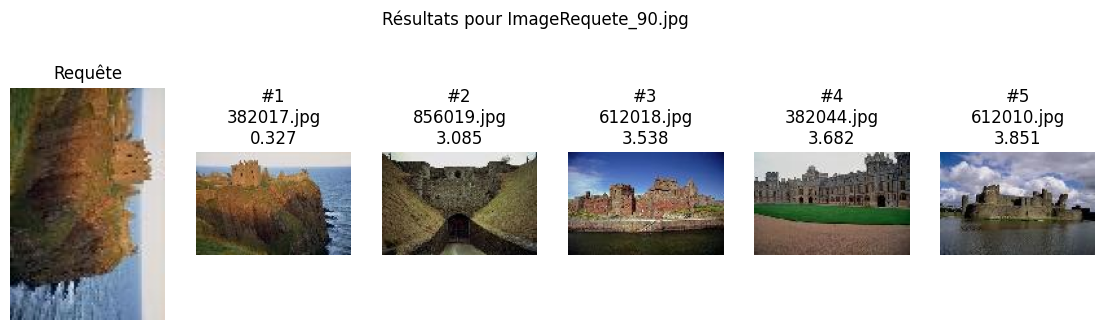

In [ ]:
for q_img, q_name in zip(query_imgs, query_names):
    results = query_image(q_img, feats_dataset_scaled, scaler, dataset_names, top_k=5)
    print(f"\n🔎 Requête : {os.path.basename(q_name)}")
    show_results(q_img, results, q_name)


## 🔄 6. Test de Robustesse face aux Transformations
Nous appliquons des transformations géométriques aux images requêtes :
- Rotation (90°)
- Redimensionnement (×0.5)
- Retournement horizontal

Puis nous comparons les résultats pour mesurer la robustesse du système.



=== 🔁 Test de robustesse pour ImageRequete.jpg ===

Transformation : rotation_90


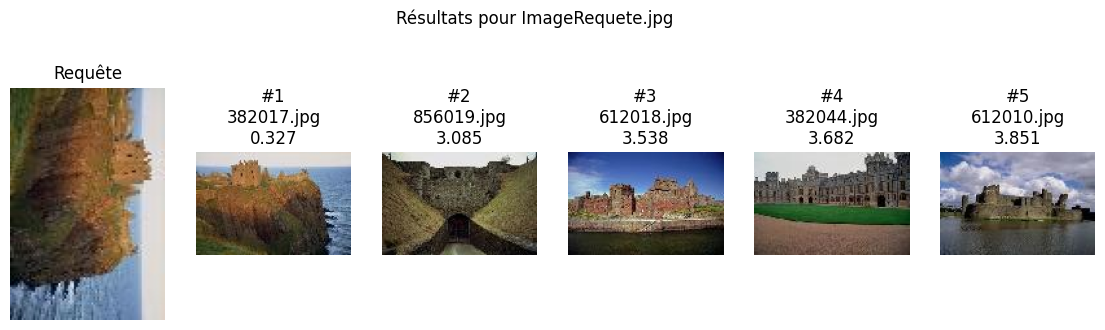


Transformation : resize_half


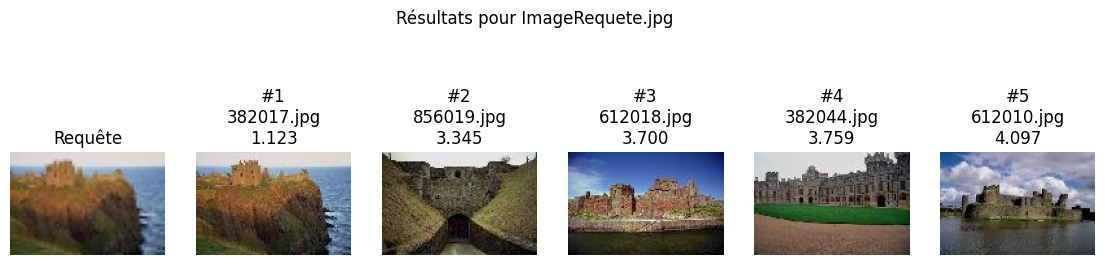


Transformation : flip


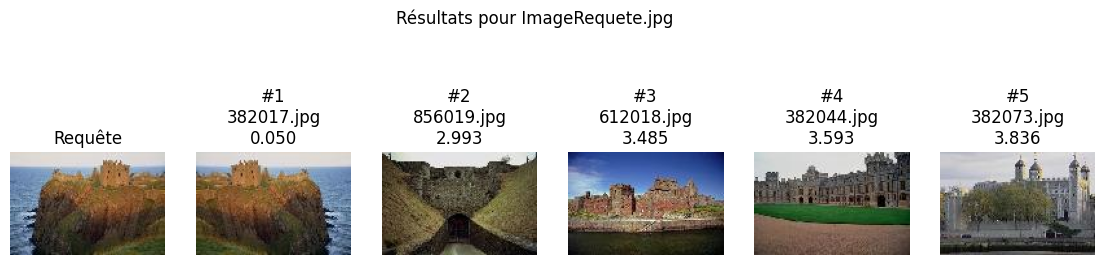


=== 🔁 Test de robustesse pour ImageRequete2.jpg ===

Transformation : rotation_90


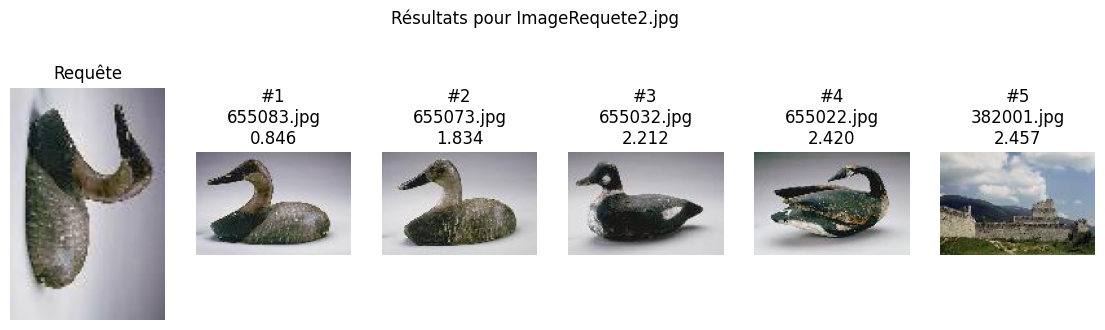


Transformation : resize_half


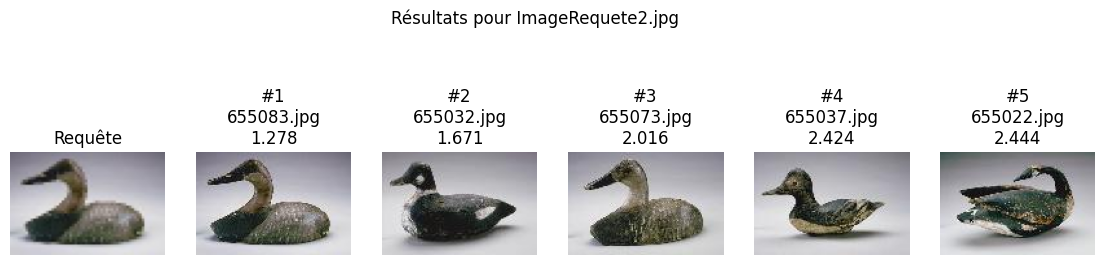


Transformation : flip


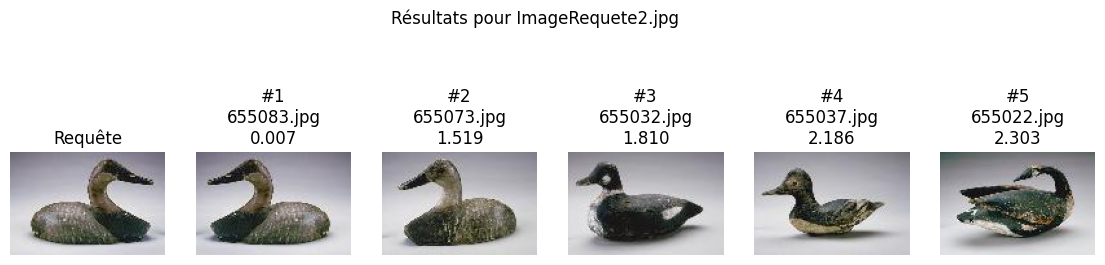


=== 🔁 Test de robustesse pour ImageRequete2_miroir_up_left .jpg ===

Transformation : rotation_90


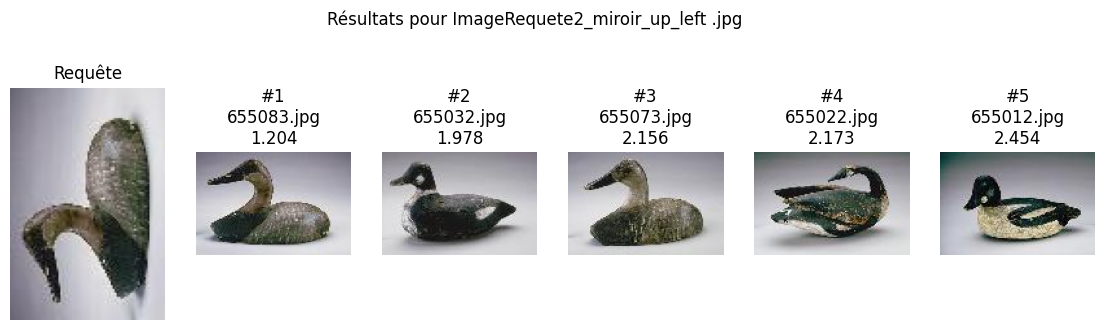


Transformation : resize_half


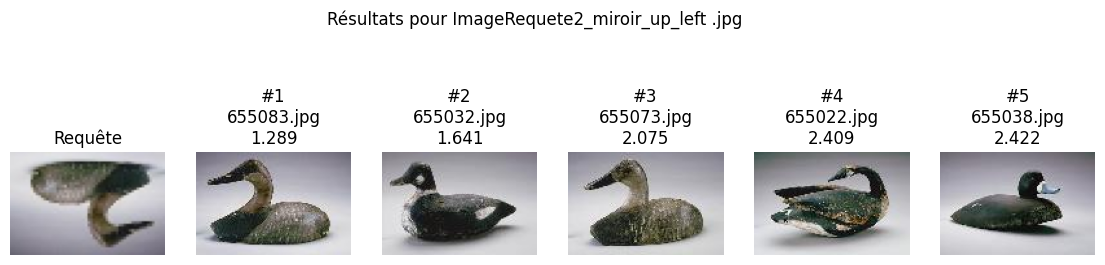


Transformation : flip


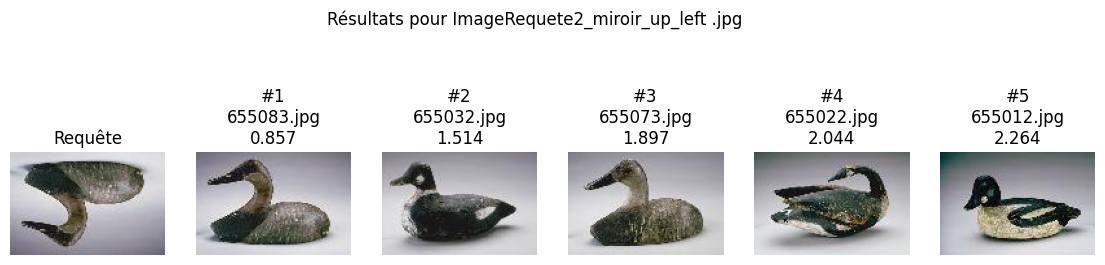


=== 🔁 Test de robustesse pour ImageRequete_90.jpg ===

Transformation : rotation_90


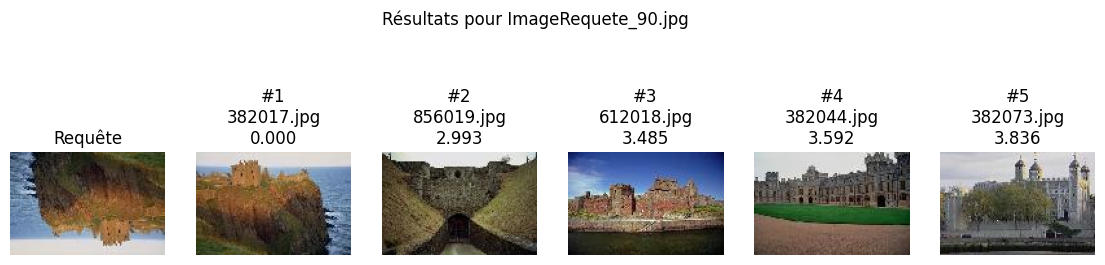


Transformation : resize_half


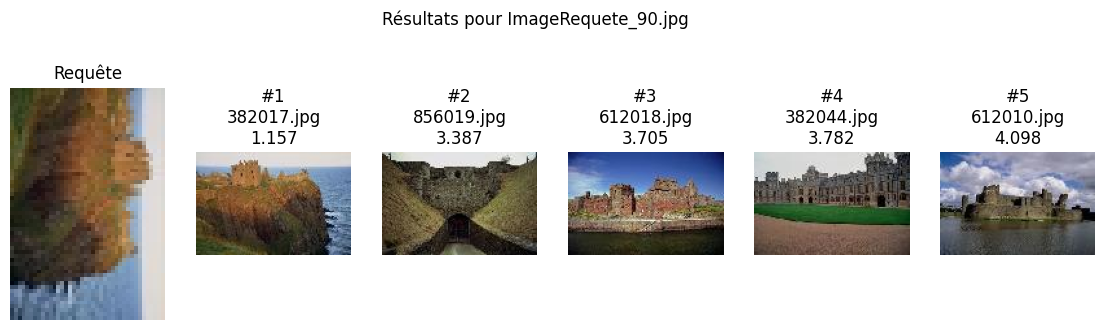


Transformation : flip


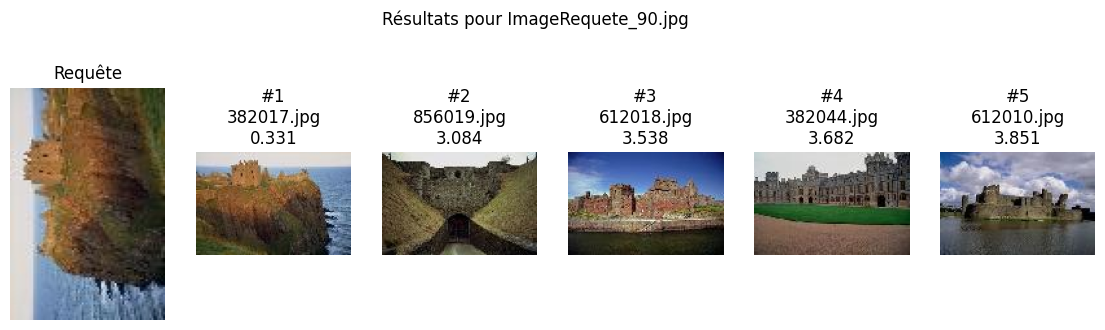

In [ ]:
def transform_image(img):
    return {
        "rotation_90": cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
        "resize_half": cv2.resize(img, (img.shape[1]//2, img.shape[0]//2)),
        "flip": cv2.flip(img, 1)
    }

for q_img, q_name in zip(query_imgs, query_names):
    print(f"\n=== 🔁 Test de robustesse pour {os.path.basename(q_name)} ===")
    trans = transform_image(q_img)
    for tname, timg in trans.items():
        results = query_image(timg, feats_dataset_scaled, scaler, dataset_names, top_k=5)
        print(f"\nTransformation : {tname}")
        show_results(timg, results, q_name)


## 📊 7. Discussion des Résultats

- **Couleur :** Les caractéristiques basées sur la couleur donnent de bons résultats lorsque les images sont peu transformées, mais sont sensibles aux changements d’éclairage ou de saturation.  
- **Texture :** Plus robuste aux petites transformations géométriques, mais dépend du niveau de gris et de la taille de l’image.  
- **Forme :** Les moments invariants de Hu sont les plus robustes aux rotations et changements d’échelle.  
- **Combinaison :** En combinant toutes les caractéristiques, on obtient un compromis équilibré entre précision et robustesse.

---

## 🧾 8. Conclusion

Le système CBIR développé démontre l’importance d’une représentation multi-caractéristiques (couleur, texture, forme).  
Les **moments de Hu** se distinguent pour leur invariance, tandis que la **couleur** permet une bonne discrimination initiale.

Pour améliorer encore le système :
- Utiliser des distances pondérées selon le type de caractéristique,  
- Intégrer des descripteurs profonds (CNN features),  
- Augmenter la base d’images pour un apprentissage plus représentatif.
